## Imports & HF Login

In [1]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # workaround for my local machine


In [2]:
import torch
# from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


from scipy import stats
from transformers import AutoTokenizer




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("cuda version:", torch.version.cuda)

Using device: cpu
cuda version: 11.8


In [3]:
from huggingface_hub import notebook_login

# log in to the Hugging Face hub (required for private datasets/models)
notebook_login()

## Load Tokenizer

In [4]:
therapist_model_id = "meta-llama/Llama-2-7b-hf"

# Load tokenizer 
#########################
tokenizer = AutoTokenizer.from_pretrained(therapist_model_id, trust_remote_code=True, device_map="auto")

# # # add the <|im_start|> and <|im_end|> tokens to the tokenizer vocab and set them as the bos and eos tokens
# tokenizer.add_tokens(['<|im_start|>', '<|im_end|>'])
# # tokenizer.add_special_tokens({'additional_special_tokens': ['<|im_start|>', '<|im_end|>']})

# tokenizer.bos_token = '<|im_start|>'
# tokenizer.eos_token = '<|im_end|>'
# set the pad token to the eos token to avoid issues with padding
tokenizer.pad_token = tokenizer.eos_token

# set the chat template to include <|im_start|> and <|im_end|> tokens
tokenizer.chat_template = "{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"


tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training
#########################
print(tokenizer.special_tokens_map)
print(tokenizer.all_special_tokens)
print([tokenizer.bos_token_id, tokenizer.eos_token_id])

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}
['<s>', '</s>', '<unk>']
[1, 2]


In [5]:
print(tokenizer.special_tokens_map)


text = "<|im_start|>. patient: I'm.<|im_end|>..."
# text = "<s>patient: I'm feeling really down today.</s><<s><"

tokens = tokenizer(text, return_tensors="pt", add_special_tokens=False)
print(tokens)
print(tokenizer.convert_ids_to_tokens(tokens["input_ids"][0]))


{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}
{'input_ids': tensor([[  529, 29989,   326, 29918,  2962, 29989, 15513, 16500, 29901,   306,
         29915, 29885, 19423, 29989,   326, 29918,   355, 29989, 29958,   856]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
['▁<', '|', 'im', '_', 'start', '|', '>.', '▁patient', ':', '▁I', "'", 'm', '.<', '|', 'im', '_', 'end', '|', '>', '...']


## Helper Functions - Load Data

In [6]:
def preprocess_conversation(conversation_pd, id=-1):
    conversation_list = conversation_pd["conversation"].tolist()
    session_endded_by = conversation_pd["session_endded_by"][0]
    session_endded_explanation = conversation_pd["session_endded_explanation"][0]

    processed_data = {
        "id": id,
        "conversation_length": len(conversation_list),
        "session_endded_by": session_endded_by,
        "session_endded_explanation": session_endded_explanation,
        "conversation": conversation_list
    }
    return processed_data


def load_conversations(data_path, start_idx=0, end_idx=96):
    """Load and preprocess conversation data from CSV files."""
    conversations = []
    for i in range(start_idx, end_idx):
        file_path = os.path.join(data_path, f"conversation_{i}.csv")
        # file_path = data_path + f"/conversation_{i}.csv"
        try:
            conversation_pd = pd.read_csv(file_path)
            conversation_dict = preprocess_conversation(conversation_pd, i)
            conversations.append(conversation_dict)
        except FileNotFoundError:
            print(f"Warning: {file_path} not found. Skipping.")
    return pd.DataFrame(conversations)

def preprocess_scores(scores_pd, id=-1):
    scores1 = scores_pd["scores1"].apply(ast.literal_eval)
    scores2 = scores_pd["scores2"].apply(ast.literal_eval)
    
    scores_dict = {
        "id": id,
        "scores1": scores1[0],
        "scores2": scores2[0],
        "scores1_avg": scores_pd["scores1_avg"][0],
        "scores2_avg": scores_pd["scores2_avg"][0],
        "scores_avg": scores_pd["scores_avg"][0],
        # "results1": scores_pd["results1"][0],
        # "results2": scores_pd["results2"][0],
    }
    return scores_dict

def load_scores(data_path, start_idx=0, end_idx=96):
    """Load and preprocess scores data from CSV files."""
    scores = []
    for i in range(start_idx, end_idx):
        file_path = os.path.join(data_path, f"scores_{i}.csv")
        # file_path = data_path + f"/scores_{i}.csv"
        try:
            score_pd = pd.read_csv(file_path)
            score_dict = preprocess_scores(score_pd, i)
            scores.append(score_dict)
        except FileNotFoundError:
            print(f"Warning: {file_path} not found. Skipping.")
    return pd.DataFrame(scores)

def load_data(data_paths):
    data_sets = []
    for data_path in data_paths:
        curr_conversations = load_conversations(data_path)
        curr_scores = load_scores(data_path)
        data_set = pd.merge(curr_conversations, curr_scores, on="id")
        data_sets.append(data_set)
    return data_sets

def combine_data(data_sets, model_names):
    combined_data = pd.concat(
        [data_set.assign(Model=model_name) for data_set, model_name in zip(data_sets, model_names)]
    )
    return combined_data

def print_conversation(conversation, max_width=80):
    """
    Print the conversation with word wrapping.

    Parameters:
        - conversation: A list of strings representing the conversation. (Therapist and Patient messages alternately, starting with the Therapist)
        - max_width: The maximum width for word wrapping. Default is 80.
    """
    for i, message in enumerate(conversation):
        role = "[THERAPIST]" if i % 2 == 0 else "[PATIENT]"
        print(f"{role}: \n{textwrap.fill(message, width=max_width)} \n")

## Load Data

In [7]:
########################### OLD EXPERIMENT DATA ###########################
########################### OLD EXPERIMENT DATA ###########################

data_paths = [
    ################# Base #################
    # "LLM_DATA/Conversation_with_Eval/Base/Instruct_TT0.7_TP0.7", # Base 50 Instruct
    "LLM_DATA/Conversation_with_Eval/Base/Basic_50_TT0.7_TP0.7_TE0.2", # Base length 50 OLD
    "LLM_DATA/Conversation_with_Eval/LookAhead_0/PartialEval_TTree1.2_TT0.7_TP0.7_TE0.2_Filter0.2_V3.0", # Lookahead=0
    "LLM_DATA/Conversation_with_Eval/LookAhead_3/FullEval_TTree1.4_TT0.7_TP0.7_TE0.2_Filter0.2_V3.0", # Lookahead=3 FullEval
    # "LLM_DATA/Conversation_with_Eval/LookAhead_5/FullEval_TTree1.2_TT0.7_TP0.7_TE0.1_Filter0.1_V3.0", # Lookahead=5 FullEval

]

model_names = [
    "Base",
    "M3_L0", # Third Iteration
    "M3_L3", # Third Iteration Lookahead=3 FullEval
    # "M3_L5", # Third Iteration Lookahead=5 FullEval
]
########################### OLD EXPERIMENT DATA ###########################
########################### OLD EXPERIMENT DATA ###########################



In [17]:
########################## NEW EXPERIMENT DATA ###########################
########################## NEW EXPERIMENT DATA ###########################

data_paths = [
    ################# Base #################
    "LLM_DATA/Conversation_with_Eval/Base/Instruct_TT0.7_TP0.7", # Base 50 Instruct
    # "LLM_DATA/Conversation_with_Eval/Base/Basic_50_TT0.9_TP0.7_TE0.2", # Base length 50
    "LLM_DATA/Conversation_with_Eval/Base/Basic_50_TT0.9_TP0.7_TE0.2_V2", # Base length 50 NEW



    ################# Look-Ahead=0, FullEval, Length=50 #################
    "LLM_DATA/Conversation_with_Eval/LookAhead_0/TTree1.4_TT0.9_TP0.7_TE0.2_V1",
    "LLM_DATA/Conversation_with_Eval/LookAhead_0/TTree1.4_TT0.9_TP0.7_TE0.2_V2",
    "LLM_DATA/Conversation_with_Eval/LookAhead_0/TTree1.4_TT0.9_TP0.7_TE0.2_V3",
    "LLM_DATA/Conversation_with_Eval/LookAhead_0/TTree1.4_TT0.9_TP0.7_TE0.2_V4",
    "LLM_DATA/Conversation_with_Eval/LookAhead_0/TTree1.4_TT0.9_TP0.7_TE0.2_V5",

    ################ Look-Ahead=5, FullEval, Length=50 #################
    # "LLM_DATA/Conversation_with_Eval/LookAhead_5/TTree1.4_TT0.9_TP0.7_TE0.2_V1",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_5/TTree1.4_TT0.9_TP0.7_TE0.2_V2",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_5/TTree1.4_TT0.9_TP0.7_TE0.2_V3",
    # "LLM_DATA/Conversation_with_Eval/LookAhead_5/TTree1.4_TT0.9_TP0.7_TE0.2_V4",

]

model_names = [
    ################# Base #################
    "Base_In", # Base 50 Instruct
    "Base",
    ################# Look-Ahead=5, FullEval, Length=50 #################
    "L0_M1",
    "L0_M2",
    "L0_M3",
    "L0_M4",
    "L0_M5",
    ################# Look-Ahead=5, FullEval, Length=50 #################
    # "L5_M1",
    # "L5_M2",
    # "L5_M3",
    # "L5_M4",
]

########################## NEW EXPERIMENT DATA ###########################
########################## NEW EXPERIMENT DATA ###########################



In [18]:
data_sets = load_data(data_paths)
combined_data = combine_data(data_sets, model_names)
# drop the id column
combined_data = combined_data.drop(columns=["id"])
# change session_endded_by to integer (therapist = 1, NaN = 0, patient = -1)
# combined_data["session_endded_by"] = combined_data["session_endded_by"].apply(lambda x: 1 if x == "therapist" else (-1 if x == "patient" else 0))
combined_data["session_endded_by"] = combined_data["session_endded_by"].apply(lambda x: x if x == "therapist" or x == "patient" else ("None"))

display(combined_data.head())
# print size of each dataset by model
#print(combined_data["Model"].value_counts())
# for each model get max, min score for scores1_avg, scores2_avg, and scores_avg
#print(combined_data.groupby("Model").agg({"scores1_avg": ["max", "min"], "scores2_avg": ["max", "min"], "scores_avg": ["max", "min"]}))

# remove rows where scores_avg is above 5 or below 1
combined_data = combined_data[(combined_data["scores_avg"] <= 5) & (combined_data["scores_avg"] >= 1)]
#print(combined_data["Model"].value_counts())

,conversation_length,session_endded_by,session_endded_explanation,conversation,scores1,scores2,scores1_avg,scores2_avg,scores_avg,Model
0,13,patient,: 2. If you are satisfied and believe that you...,"[My name is David, and I'm a counselor, can yo...","[4, 4, 4, 4, 4]","[4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 3, 4, 4, 4, 5, ...",4.0,3.947368,3.973684,Base_In
1,15,patient,NaN,"[My name is David, and I'm a counselor, can yo...","[3, 3, 2, 2, 2]","[4, 4, 3, 4, 4, 4, 3, 3, 3, 5, 3, 4, 4, 3, 5, ...",2.4,3.736842,3.068421,Base_In
2,19,patient,NaN,"[My name is David, and I'm a counselor, can yo...","[5, 5, 5, 5, 5]","[4, 4, 3, 4, 5, 4, 4, 4, 4, 5, 3, 4, 4, 4, 5, ...",5.0,4.052632,4.526316,Base_In
3,17,patient,NaN,"[My name is David, and I'm a counselor, can yo...","[4, 4, 3, 4, 4]","[4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, ...",3.8,4.105263,3.952632,Base_In
4,33,patient,NaN,"[My name is David, and I'm a counselor, can yo...","[4, 4, 4, 4, 4]","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",4.0,4.000000,4.000000,Base_In


## EDA

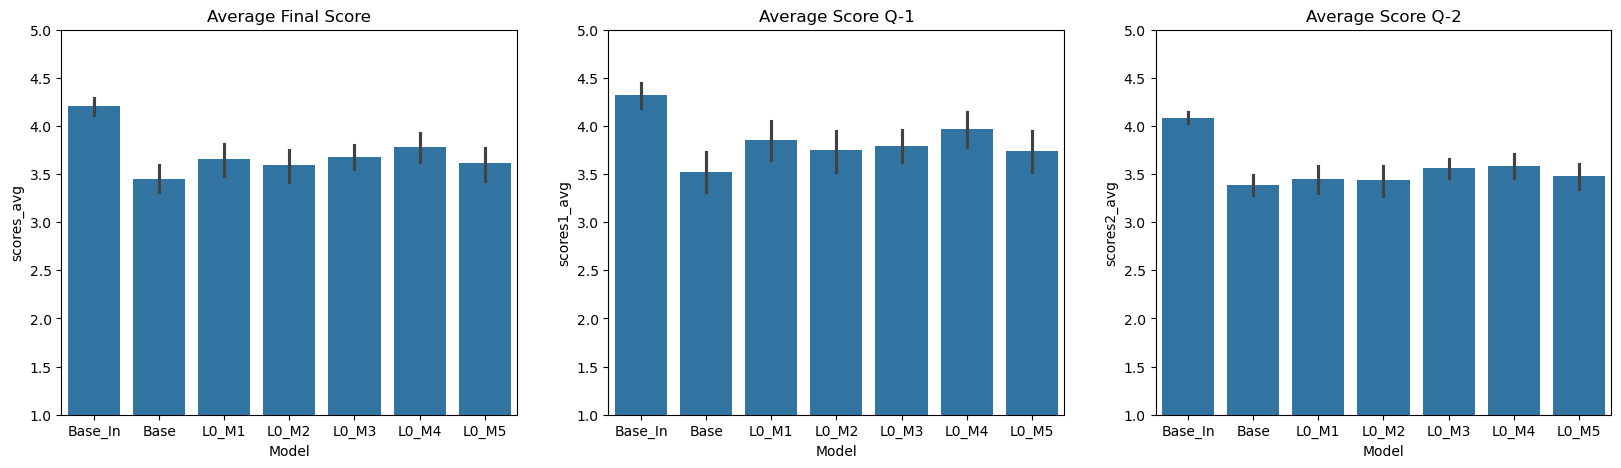

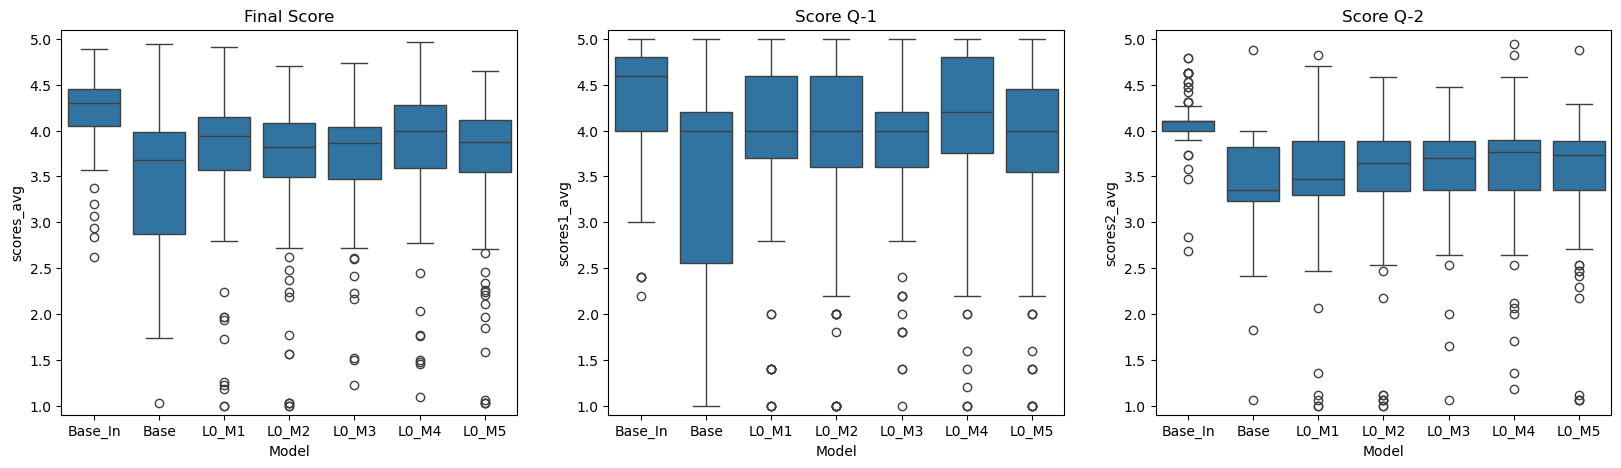

Average Scores:
            Q1     Q2  Final
Model                       
Base     3.521  3.385  3.453
Base_In  4.321  4.087  4.204
L0_M1    3.857  3.453  3.655
L0_M2    3.750  3.435  3.593
L0_M3    3.796  3.567  3.682
L0_M4    3.969  3.585  3.777
L0_M5    3.744  3.478  3.611

Standard Deviation of Scores:
            Q1     Q2  Final
Model                       
Base     1.056  0.539  0.740
Base_In  0.626  0.294  0.413
L0_M1    1.016  0.735  0.828
L0_M2    1.059  0.788  0.878
L0_M3    0.868  0.511  0.649
L0_M4    0.979  0.642  0.769
L0_M5    1.124  0.687  0.856


In [19]:
# group combined_data by model
grouped_data = combined_data.groupby("Model")

# plot the average scores for each model (scores_avg, scores1_avg, scores2_avg)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.barplot(x="Model", y="scores_avg", data=combined_data, ax=ax[0])
sns.barplot(x="Model", y="scores1_avg", data=combined_data, ax=ax[1])
sns.barplot(x="Model", y="scores2_avg", data=combined_data, ax=ax[2])
ax[0].set_title("Average Final Score")
ax[1].set_title("Average Score Q-1")
ax[2].set_title("Average Score Q-2")
for a in ax:
    a.set_ylim(1, 5)
plt.show()

# boxplot of scores for each model
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.boxplot(x="Model", y="scores_avg", data=combined_data, ax=ax[0])
sns.boxplot(x="Model", y="scores1_avg", data=combined_data, ax=ax[1])
sns.boxplot(x="Model", y="scores2_avg", data=combined_data, ax=ax[2])
ax[0].set_title("Final Score")
ax[1].set_title("Score Q-1")
ax[2].set_title("Score Q-2")
for a in ax:
    a.set_ylim(0.9, 5.1)
plt.show()


# print table of average scores for each model and each question
avg = (combined_data.groupby("Model")[["scores1_avg", "scores2_avg", "scores_avg"]].mean().round(3))

# print std of scores for each model and each question
std = (combined_data.groupby("Model")[["scores1_avg", "scores2_avg", "scores_avg"]].std().round(3))

# in avg and std, change the column names to Q1, Q2, and Final
avg.columns = ["Q1", "Q2", "Final"]
std.columns = ["Q1", "Q2", "Final"]
print("Average Scores:")
print(avg)
print()
print("Standard Deviation of Scores:")
print(std)

# check significance of difference between scores1_avg and scores2_avg and scores_avg between each model (ANOVA)







In [ ]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
key_to_str = { "scores_avg": "Final Score", "scores1_avg": "Q1", "scores2_avg": "Q2" }
str_to_key = { "Final Score": "scores_avg", "Q1": "scores1_avg", "Q2": "scores2_avg" }

# Assuming combined_data is already defined and contains "Model", "scores_avg", "scores1_avg", and "scores2_avg" columns.

# One-way ANOVA for each score type
anova_results = {
    "Final Score": f_oneway(*(combined_data[combined_data["Model"] == model]["scores_avg"] for model in combined_data["Model"].unique())),
    "Q1": f_oneway(*(combined_data[combined_data["Model"] == model]["scores1_avg"] for model in combined_data["Model"].unique())),
    "Q2": f_oneway(*(combined_data[combined_data["Model"] == model]["scores2_avg"] for model in combined_data["Model"].unique()))
}

# Print ANOVA results
for score_type, result in anova_results.items():
    print(f"ANOVA result for {score_type}: F={result.statistic:.3f}, p={result.pvalue:.3e}")

# Tukey's HSD test for post-hoc comparisons
print("\nTukey's HSD Test Results:")

# Perform Tukey's HSD for each score type
for score_type in ["scores_avg", "scores1_avg", "scores2_avg"]:
    tukey_result = pairwise_tukeyhsd(endog=combined_data[score_type], groups=combined_data["Model"], alpha=0.05)
    print(f"\nPost-hoc Tukey HSD results for {key_to_str[score_type]}:")
    print(tukey_result)


ANOVA result for Final Score: F=9.771, p=2.47e-10
ANOVA result for Q1: F=6.218, p=2.30e-06
ANOVA result for Q2: F=14.289, p=2.36e-15

Tukey's HSD Test Results:

Post-hoc Tukey HSD results for Final Score:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
   Base Base_In   0.7509    0.0  0.4315  1.0703   True
   Base   L0_M1   0.2016 0.5066 -0.1186  0.5219  False
   Base   L0_M2   0.1394 0.8562   -0.18  0.4588  False
   Base   L0_M3   0.2285 0.3445 -0.0909  0.5479  False
   Base   L0_M4   0.3235 0.0448  0.0041  0.6429   True
   Base   L0_M5   0.1577 0.7682 -0.1617  0.4771  False
Base_In   L0_M1  -0.5493    0.0 -0.8695  -0.229   True
Base_In   L0_M2  -0.6115    0.0 -0.9309 -0.2921   True
Base_In   L0_M3  -0.5224    0.0 -0.8418  -0.203   True
Base_In   L0_M4  -0.4273 0.0016 -0.7467 -0.1079   True
Base_In   L0_M5  -0.5932    0.0 -0.9126 -0.2738   True
  L0_M1   L0_M2  -0.0622 

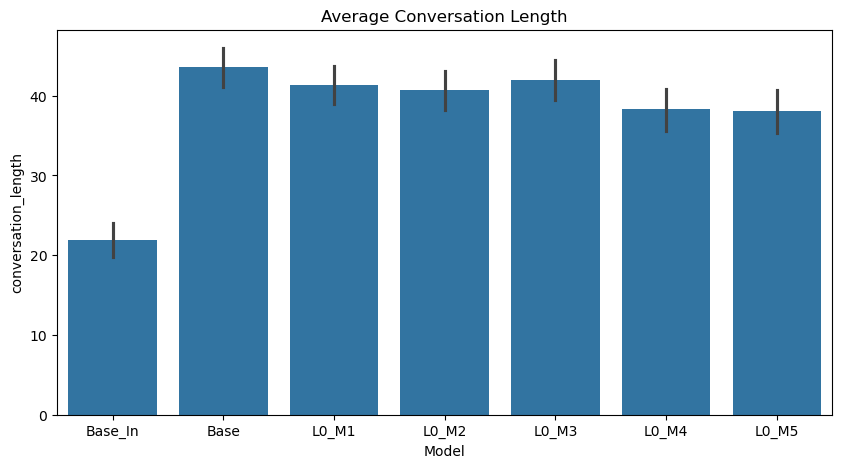

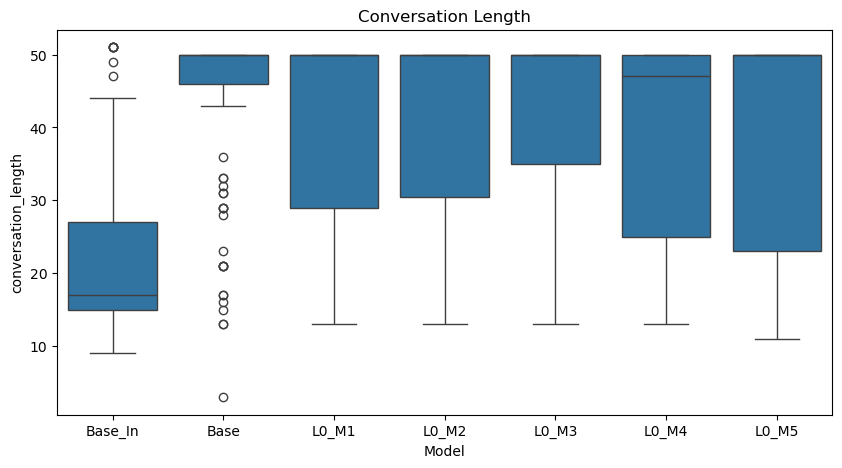

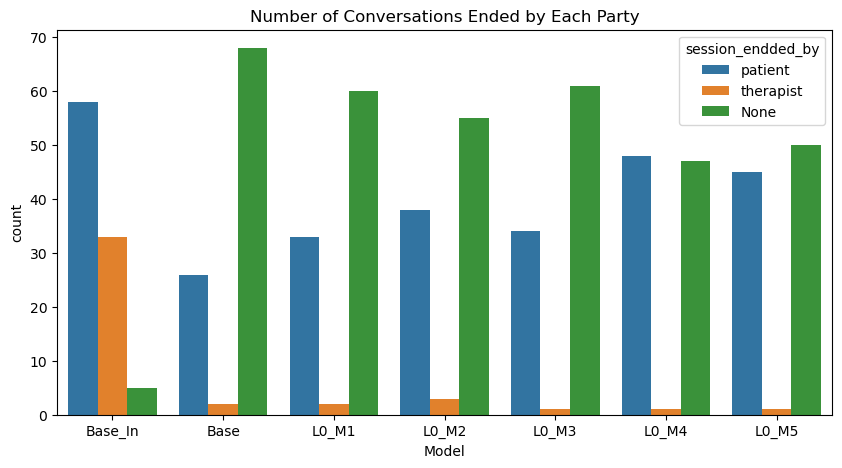

In [21]:
# plot the average conversation length for each model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(x="Model", y="conversation_length", data=combined_data, ax=ax)
ax.set_title("Average Conversation Length")
plt.show()

# box plot of conversation length for each model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(x="Model", y="conversation_length", data=combined_data, ax=ax)
ax.set_title("Conversation Length")
plt.show()

# plot the number of conversations that ended with each party for each model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="Model", hue="session_endded_by", data=combined_data, ax=ax)
ax.set_title("Number of Conversations Ended by Each Party")
plt.show()

In [22]:
# # show the difference in scores between conversation that ended with the therapist and those that ended with the patient and those that did not end at all. for each model separately.
# num_models = len(model_names)
# fix, ax = plt.subplots(num_models, 3, figsize=(20, 5*num_models))
# for i, (model_name, model_data) in enumerate(grouped_data):
#     sns.boxplot(x="session_endded_by", y="scores_avg", data=model_data, ax=ax[i][0])
#     sns.boxplot(x="session_endded_by", y="scores1_avg", data=model_data, ax=ax[i][1])
#     sns.boxplot(x="session_endded_by", y="scores2_avg", data=model_data, ax=ax[i][2])
#     ax[i][0].set_title(f"{model_name} - Average Score")
#     ax[i][1].set_title(f"{model_name} - Average Score 1")
#     ax[i][2].set_title(f"{model_name} - Average Score 2")
# plt.show()
    

In [23]:
threshold_score = 5

# for each model get all conversations that ended with final score below 2
bad_conversations = combined_data[combined_data["scores_avg"] <= threshold_score]
print("Total Number of bad conversations:", len(bad_conversations))
for model_name in model_names:
    model_data = combined_data[combined_data["Model"] == model_name]
    model_bad_conversations = model_data[model_data["scores_avg"] <= threshold_score]
    print(f"Number of bad conversations for {model_name}:", len(model_bad_conversations))
    bad_conversations_indices = model_bad_conversations.index
    bad_conversations_scores = (model_bad_conversations["scores_avg"], model_bad_conversations["scores1_avg"], model_bad_conversations["scores2_avg"])
    bad_conversations_scores = list(zip(*bad_conversations_scores))
    bad_conversations_scores = np.array(bad_conversations_scores)
    print("Bad Conversations indices:", bad_conversations_indices)
    print("Bad Conversations scores:", bad_conversations_scores)
    print("-"*42)
    print("\n\n")



Total Number of bad conversations: 671
Number of bad conversations for Base_In: 96
Bad Conversations indices: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95],
      dtype='int64')
Bad Conversations scores: [[3.97368421 4.         3.94736842]
 [3.06842105 2.4        3.73684211]
 [4.52631579 5.         4.05263158]
 [3.95263158 3.8        4.10526316]
 [4.         4.         4.        ]
 [4.07368421 4.2        3.94736842]
 [4.45263158 4.8        4.10526316]
 [4.32631579 4.6        4.05263158]
 [3.67368421 3.4        3.94736842]
 [3.87368421 3.8        3.94736842]
 [4.05263158 4.         4.10526316]
 [3.72631579 3.4    

In [24]:

# # for each model get all conversations that ended with final score below 2
# bad_conversations = combined_data[combined_data["scores1_avg"] <= threshold_score]
# print("Total Number of bad conversations:", len(bad_conversations))
# for model_name in model_names:
#     model_data = combined_data[combined_data["Model"] == model_name]
#     model_bad_conversations = model_data[model_data["scores1_avg"] <= threshold_score]
#     print(f"Number of bad conversations for {model_name}:", len(model_bad_conversations))
#     bad_conversations_indices = model_bad_conversations.index
#     bad_conversations_scores = model_bad_conversations["scores1_avg"]
#     print("Bad Conversations indices:", bad_conversations_indices)
#     print("Bad Conversations scores:", bad_conversations_scores)
#     print("-"*42)
#     print("\n\n")



In [25]:

# # for each model get all conversations that ended with final score below 2
# bad_conversations = combined_data[combined_data["scores2_avg"] <= threshold_score]
# print("Total Number of bad conversations:", len(bad_conversations))
# for model_name in model_names:
#     model_data = combined_data[combined_data["Model"] == model_name]
#     model_bad_conversations = model_data[model_data["scores2_avg"] <= threshold_score]
#     print(f"Number of bad conversations for {model_name}:", len(model_bad_conversations))
#     bad_conversations_indices = model_bad_conversations.index
#     bad_conversations_scores = model_bad_conversations["scores2_avg"]
#     print("Bad Conversations indices:", bad_conversations_indices)
#     print("Bad Conversations scores:", bad_conversations_scores)
#     print("-"*42)
#     print("\n\n")

